In [72]:
import pandas as pd

tweets = pd.read_csv("data.csv")

tweets.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1


In [51]:
len(tweets)

226834

In [ ]:
import re

def remove_non_letters(text):

    cleaned_text = re.sub(r'[^а-яА-Я]', ' ', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    cleaned_text = cleaned_text.strip()

    return cleaned_text


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))

def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    cleaned_text = ' '.join(words)

    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from pymystem3 import Mystem

mystem = Mystem()

def lemmatize_text(text):

    lemmatized = mystem.lemmatize(text)
    lemmatized_text = ''.join(lemmatized).strip()

    return lemmatized_text


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
def preprocessing(text):
    clean_text = remove_stopwords(remove_non_letters(text))
    lem_text = lemmatize_text(clean_text)

    return lem_text


Удаление стоп-слов + лемматизация

In [73]:
tweets['text'] = tweets['text'].apply(preprocessing)

In [53]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226834 entries, 0 to 226833
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    226834 non-null  object
 1   label   226834 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [74]:
tweets['text'].iloc[0]

'школоть поверять самый общество профилировать предмет тип'

In [75]:
tweets[tweets['text'].str.len() >= 25]

,text,label
0,школоть поверять самый общество профилировать ...,1
1,таки немного похожий мальчик равный,1
3,угол сидеть погибать голод ещ порция взять хот...,1
4,значит страшилка блин посмотреть часть создава...,1
8,поприветствовать мой новый читатель,1
...,...,...
226826,сказать пожалуйста человек одноклассник,0
226827,физ ра улица пак линт минута прийти пхжааххв,0
226828,сегодня отказываться принимать сад тип плач ко...,0
226830,скучать вправлять мозги равный скучать,0


In [ ]:
tweets.to_csv('preprocessed_data.csv', index=False, encoding='cp1251')

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

tweets = tweets.dropna()


tfidf_vectorizer = TfidfVectorizer()

text_vector = tfidf_vectorizer.fit_transform(tweets['text'])

text_vector

<226834x93530 sparse matrix of type '<class 'numpy.float64'>'
	with 1436680 stored elements in Compressed Sparse Row format>

In [43]:
text_vector.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_vector, tweets['label'].apply(lambda x: int(x)), test_size=0.33, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.73      0.69      0.71     37098
           1       0.71      0.75      0.73     37758

    accuracy                           0.72     74856
   macro avg       0.72      0.72      0.72     74856
weighted avg       0.72      0.72      0.72     74856



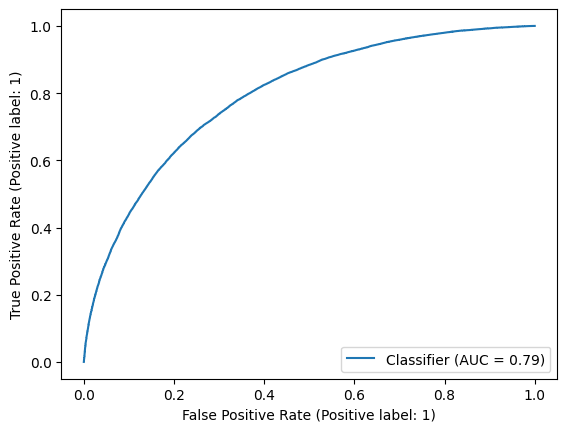

In [78]:
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

model = LogisticRegression()

model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds))
roc_display = RocCurveDisplay.from_predictions(y_test, model.predict_proba(X_test)[:,1])

Удаление ссылок

In [80]:
def remove_links(text):
  link_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  cleaned_text = re.sub(link_pattern, '', text)
  return cleaned_text

tweets_noNorm = pd.read_csv("data.csv")
tweets_noNorm['text'] = tweets_noNorm['text'].apply(lambda x: remove_links(x))

In [81]:
tweets_noNorm = tweets_noNorm.dropna()

tfidf_vectorizer = TfidfVectorizer()

text_vector_noNorm = tfidf_vectorizer.fit_transform(tweets_noNorm['text'])

X_train, X_test, y_train, y_test = train_test_split(text_vector_noNorm,
                                                    tweets_noNorm['label'].apply(lambda x: int(x)),
                                                    test_size=0.33, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.77      0.72      0.74     37098
           1       0.74      0.79      0.77     37758

    accuracy                           0.76     74856
   macro avg       0.76      0.76      0.76     74856
weighted avg       0.76      0.76      0.76     74856



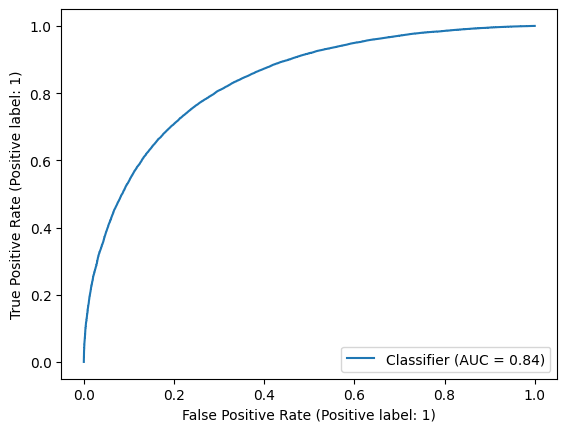

In [82]:
model_noNorm = LogisticRegression()

model_noNorm.fit(X_train, y_train)

preds = model_noNorm.predict(X_test)

print(classification_report(y_test, preds))
RocCurveDisplay.from_predictions(y_test, model_noNorm.predict_proba(X_test)[:,1])

Удаление ссылок и стоп-слов + кросс-валидация

In [83]:
def final_preprocessing(text):
  no_links = remove_links(text)
  no_stop_words = remove_stopwords(no_links)
  return no_stop_words

final_tweets = pd.read_csv('data.csv')

final_tweets['text'] = final_tweets['text'].apply(lambda x: final_preprocessing(x))

final_tweets = final_tweets.dropna()

tfidf_vectorizer = TfidfVectorizer()

final_text_vector = tfidf_vectorizer.fit_transform(final_tweets['text'])

X_train, X_test, y_train, y_test = train_test_split(final_text_vector,
                                                    final_tweets['label'].apply(lambda x: int(x)),
                                                    test_size=0.3, random_state=42)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START C=0.8.......................................................
[CV 1/5; 1/2] END ........................C=0.8;, score=0.741 total time=  21.7s
[CV 2/5; 1/2] START C=0.8.......................................................
[CV 2/5; 1/2] END ........................C=0.8;, score=0.740 total time=  17.7s
[CV 3/5; 1/2] START C=0.8.......................................................
[CV 3/5; 1/2] END ........................C=0.8;, score=0.742 total time=  21.8s
[CV 4/5; 1/2] START C=0.8.......................................................
[CV 4/5; 1/2] END ........................C=0.8;, score=0.746 total time=  13.9s
[CV 5/5; 1/2] START C=0.8.......................................................
[CV 5/5; 1/2] END ........................C=0.8;, score=0.741 total time=  23.3s
[CV 1/5; 2/2] START C=0.9.......................................................
[CV 1/5; 2/2] END ........................C=0.9;,

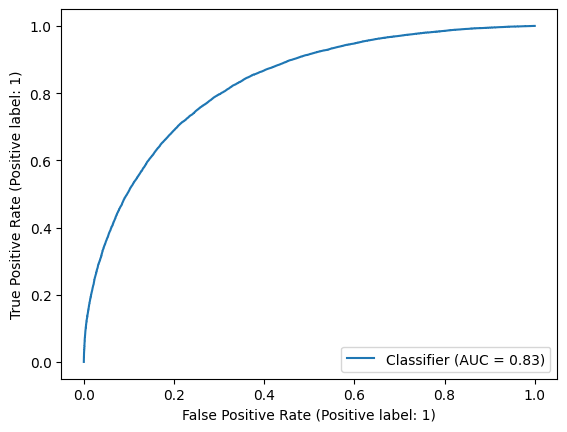

In [96]:
from sklearn.model_selection import GridSearchCV
import numpy as np
final_model = GridSearchCV(estimator=LogisticRegression(max_iter=100000),
                           param_grid={'C': np.arange(.8, 1, 0.1)},
                           verbose=50)

final_model.fit(X_train, y_train)

preds = final_model.predict(X_test)

print(classification_report(y_test, preds))
RocCurveDisplay.from_predictions(y_test, final_model.predict_proba(X_test)[:,1])



In [97]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer_tweets = pd.read_csv("data.csv")

tweets_noNorm['text'] = tweets_noNorm['text'].apply(lambda x: final_preprocessing(x))

final_tweets = final_tweets.dropna()

count_vectorizer = CountVectorizer(ngram_range=(2, 2))

count_vectorizer_vector = count_vectorizer.fit_transform(final_tweets['text'])

X_train, X_test, y_train, y_test = train_test_split(count_vectorizer_vector,
                                                    final_tweets['label'].apply(lambda x: int(x)),
                                                    test_size=0.3, random_state=42)


In [99]:
!pip install nltk

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     33752
           1       0.76      0.75      0.75     34299

    accuracy                           0.75     68051
   macro avg       0.75      0.75      0.75     68051
weighted avg       0.75      0.75      0.75     68051

              precision    recall  f1-score   support

           0       0.61      0.79      0.69     33752
           1       0.71      0.51      0.59     34299

    accuracy                           0.65     68051
   macro avg       0.66      0.65      0.64     68051
weighted avg       0.66      0.65      0.64     68051

              precision    recall  f1-score   support

           0       0.53      0.97      0.69     33752
           1       0.84      0.16      0.28     34299

    accuracy                           0.56     68051
   macro avg       0.69      0.57      0.48     68051
weighted avg       0.69      0.56      0.48     68051



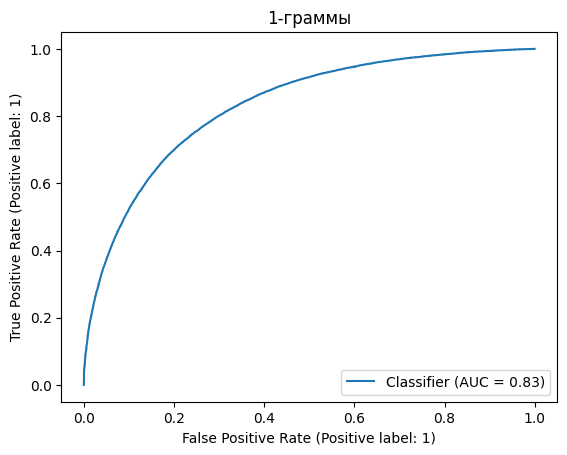

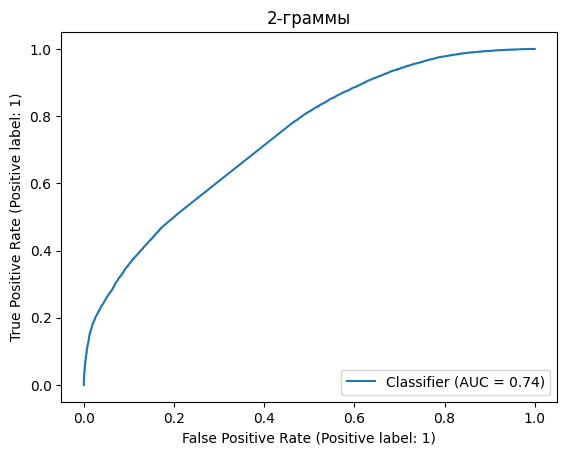

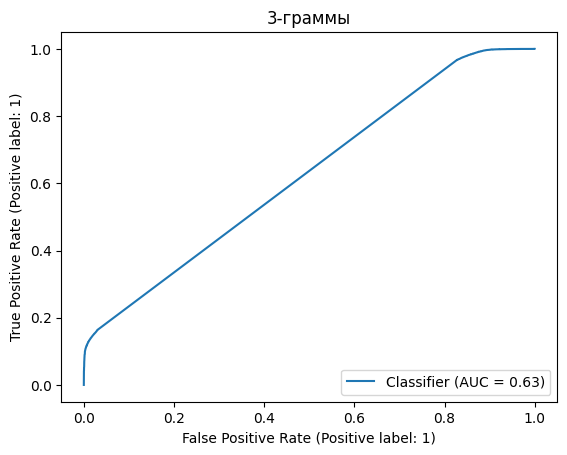

In [108]:
for i in range(1,4):
  count_vectorizer = CountVectorizer(ngram_range=(i, i))

  count_vectorizer_vector = count_vectorizer.fit_transform(final_tweets['text'])

  X_train, X_test, y_train, y_test = train_test_split(count_vectorizer_vector,
                                                    final_tweets['label'].apply(lambda x: int(x)),
                                                    test_size=0.3, random_state=42)

  final_model = LogisticRegression(max_iter=1000)

  final_model.fit(X_train, y_train)

  preds = final_model.predict(X_test)

  print(classification_report(y_test, preds))
  RocCurveDisplay.from_predictions(y_test, final_model.predict_proba(X_test)[:,1])
  plt.title(f'{i}-граммы')